# E-COMMERCE SALES FORECASTING

## Introduction 
In today’s competitive business environment, accurate sales forecasting plays a critical role in decision-making for inventory planning, marketing strategy, and resource allocation. Organizations rely on historical sales data to anticipate future demand and identify the factors influencing sales patterns. In this project, we aim to build a machine learning model capable of predicting the number of units sold over the next 90 days. The solution will incorporate data preprocessing, exploratory analysis, feature engineering, and predictive modeling using algorithms such as Linear Regression, Random Forest, and XGBoost. The final product will be deployed as a Streamlit web app for easy use by business stakeholders.

## Business Understanding
The core objective is to predict daily sales (Units_Sold) for the next 30 days based on historical patterns and influencing factors such as product category, pricing, discount levels, customer segmentation, and marketing spend.
Accurate predictions will allow the business to:

- Plan inventory levels to avoid stockouts or overstock situations.
- Adjust marketing campaigns to align with projected demand.
- Optimize pricing and discount strategies for maximum profitability.
- Allocate resources effectively to high-demand products or customer segments.

The key **stakeholders** for this initiative include product managers, who will focus on SKU and category-level forecasts; the supply chain and procurement teams, who will rely on accurate projections to optimize sourcing and inventory management; marketing teams, who will use the data to evaluate campaign return on investment; and the finance department, which will leverage the insights for revenue planning.

The **metric of success** of this model will be measured by its predictive accuracy i.e RMSE, MAE and its usefulness in guiding strategic decisions.



## Data Understanding
The dataset consists of the following columns:

- Date - Date of the sales record.
- Product_Category - Category of the product sold.
- Price - Selling price of the product.
- Discount - Discount offered on the product
- Customer_Segment - Segment of the customer (e.g., retail, wholesale, online).
- Marketing_Spend	- Marketing expenditure associated with that day/product.
- Units_Sold	- Number of units sold (target variable).

The dataset covers multiple influencing factors that can affect sales performance. It will be crucial to check for missing values, outliers, and data inconsistencies during preprocessing. We will also create time-based features (like moving averages and lag features) to capture seasonality and trends.

In [1]:
# Standard data libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Modeling / preprocessing
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from scipy import stats

# Prophet for per-series forecasting
from prophet import Prophet
import holidays

# Persistence
import joblib
import pickle
import os

# For Streamlit UI (import at runtime when launching app)
import streamlit as st
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

RND = 42  # reproducibility

In [2]:
# Loading data
data = pd.read_csv('Ecommerce_Sales_Prediction_Dataset.csv')
data.head()

,Date,Product_Category,Price,Discount,Customer_Segment,Marketing_Spend,Units_Sold
0,01-01-2023,Sports,932.80,35.82,Occasional,6780.38,32
1,02-01-2023,Toys,569.48,3.60,Premium,6807.56,16
2,03-01-2023,Home Decor,699.68,3.56,Premium,3793.91,27
3,04-01-2023,Toys,923.27,0.61,Premium,9422.75,29
4,05-01-2023,Toys,710.17,47.83,Premium,1756.83,17


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              1000 non-null   object 
 1   Product_Category  1000 non-null   object 
 2   Price             1000 non-null   float64
 3   Discount          1000 non-null   float64
 4   Customer_Segment  1000 non-null   object 
 5   Marketing_Spend   1000 non-null   float64
 6   Units_Sold        1000 non-null   int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 54.8+ KB


In [4]:
#Check for missing values
data.isnull().sum()

Date                0
Product_Category    0
Price               0
Discount            0
Customer_Segment    0
Marketing_Spend     0
Units_Sold          0
dtype: int64

In [5]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,1000,1000,01-01-2023,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product_Category,1000,5,Electronics,210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,1000.0,NaN,NaN,NaN,505.24192,289.791248,14.59,243.3425,509.31,747.5925,999.42
Discount,1000.0,NaN,NaN,NaN,24.91975,14.439951,0.01,12.995,24.965,37.5625,49.92
Customer_Segment,1000,3,Regular,345,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marketing_Spend,1000.0,NaN,NaN,NaN,4912.83024,2840.602656,100.3,2413.02,4837.245,7319.675,9995.62
Units_Sold,1000.0,NaN,NaN,NaN,29.631,7.267989,5.0,24.0,30.0,34.0,57.0


## Data Cleaning and Preprocessing

In [6]:
# Sorting by date for time operations
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors="coerce")
data = data.sort_values(by='Date')

In [7]:
#Checking for outliers
Q1 = data['Units_Sold'].quantile(0.25)
Q3 = data['Units_Sold'].quantile(0.75)
IQR = Q3 - Q1
IQR

10.0

***Observation***

The interquartile range (IQR) for Units_Sold is 10.0, meaning the middle 50% of sales data falls within a range of 10 units. This suggests moderate spread/variability in the central portion of the sales data.

In [8]:
# Define outlier boundaries (1.5 * IQR is standard)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_mask = (data['Units_Sold'] < lower_bound) | (data['Units_Sold'] > upper_bound)
outliers_count = outliers_mask.sum()

if outliers_count > 0:
    # BUSINESS DECISION: Cap instead of remove (preserve data volume)
        data['Units_Sold'] = data['Units_Sold'].clip(lower_bound, upper_bound)

print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)
print("Outliers:", outliers_count)


Lower Bound: 9.0
Upper Bound: 49.0
Outliers: 5


***Observation***

There are no outliers in the Units_Sold column based on the 1.5 * IQR rule. The lower bound is 9.0 and the upper bound is 49.0, so all Units_Sold values fall within this range.

In [9]:
# Ensure non-negative values where business logic requires
(data['Units_Sold'] < 0).any()

False

In [10]:
#Sort by date (crucial for time series)
data = data.sort_values('Date').reset_index(drop=True)
data.head()

,Date,Product_Category,Price,Discount,Customer_Segment,Marketing_Spend,Units_Sold
0,2023-01-01,Sports,932.80,35.82,Occasional,6780.38,32
1,2023-01-02,Toys,569.48,3.60,Premium,6807.56,16
2,2023-01-03,Home Decor,699.68,3.56,Premium,3793.91,27
3,2023-01-04,Toys,923.27,0.61,Premium,9422.75,29
4,2023-01-05,Toys,710.17,47.83,Premium,1756.83,17


## Exploratory Data Analysis

In [11]:
# Time series visualization with Plotly (interactive)
fig_timeline = go.Figure()


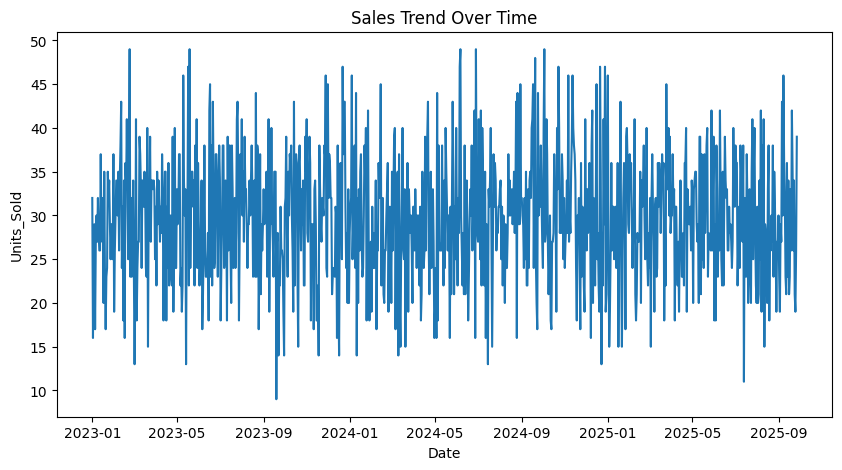

In [12]:
# Aggregate daily sales
plt.figure(figsize=(10,5))
sns.lineplot(x="Date", y="Units_Sold", data=data)
plt.title("Sales Trend Over Time")
plt.show()

***Observation:***

The daily sales time series plot shows the trend and fluctuations of units sold over time. You can observe periods of higher and lower sales, as well as any seasonality or irregular spikes in demand. If the line is relatively stable, sales are consistent; if there are peaks and troughs, sales are more variable. This visualization helps identify overall sales patterns, trends, and potential anomalies in daily sales.

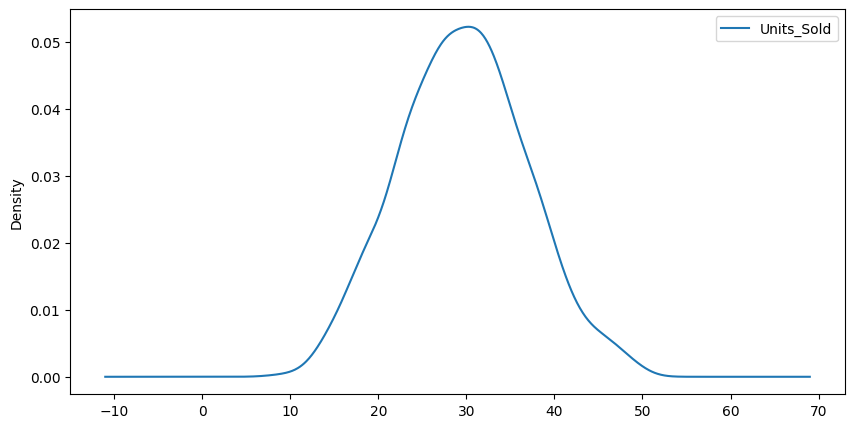

In [13]:
data.plot(kind='kde', y='Units_Sold', figsize=(10,5));

***Observation:***

The KDE plot for Units Sold shows a single, prominent peak around 30 units, indicating that most daily sales cluster near this value. The distribution is fairly symmetric with a slight right skew, suggesting that while most sales are consistent, there are occasional days with higher sales. There are very few days with extremely low or extremely high sales.

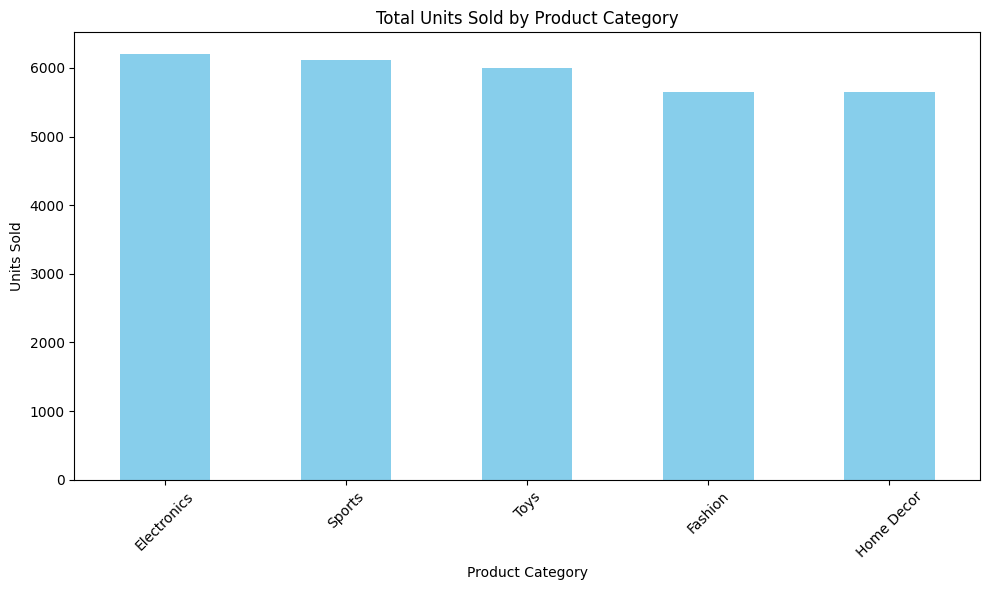

In [14]:
# Category analysis
category_sales = data.groupby('Product_Category')['Units_Sold'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
category_sales.plot(kind='bar', color='skyblue')
plt.title('Total Units Sold by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***Observation***

Electronics and Sports have the highest sales, while Fashion and Home Decor have the lowest. Sales are fairly balanced across categories.

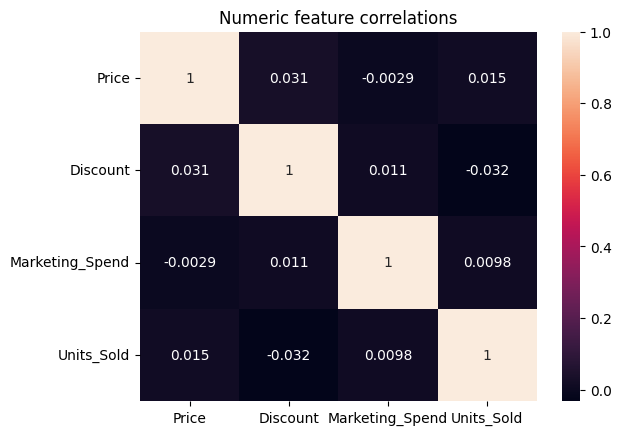

In [15]:
# Correlation analysis among numeric features
num = data[['Price','Discount','Marketing_Spend','Units_Sold']]
sns.heatmap(num.corr(), annot=True)
plt.title('Numeric feature correlations')
plt.show()

***Observation***

There is no strong correlation between Units Sold and any of the numeric features (Price, Discount, or Marketing Spend). All correlations are very weak.

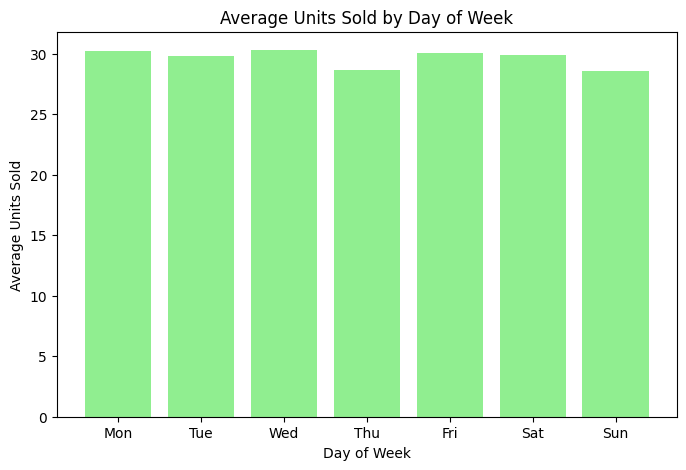

In [16]:
# 4. Seasonality view: average by day of week
dow = data.groupby(data['Date'].dt.dayofweek)['Units_Sold'].mean()


dow = data.groupby(data['Date'].dt.dayofweek)['Units_Sold'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(8,5))
plt.bar(days, dow.values, color='lightgreen')
plt.title('Average Units Sold by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Units Sold')
plt.show()

***Observation***

Sales are fairly consistent across the week, with no significant spikes or drops on any particular day. This suggests there is no strong day-of-week seasonality in units sold.

## Data Preprocessing
### Feature Engineering

In [17]:
# Create feature engineering copy
data_features = data.copy()

In [18]:
def create_advanced_features(
    data_features, 
    group_col='Product_Category', 
    target='Units_Sold',
    lags=[1,7,14], 
    rolling_windows=[7,14,30],
    ewm_spans=[7,14,30],
    country_holidays='US'  # US by default, can change to 'KE', etc.
):
    data_features = data_features.copy()
    data_features = data_features.sort_values([group_col, 'Date'])
    
    # --- Lag features ---
    for lag in lags:
        data_features[f'lag_{lag}'] = data_features.groupby(group_col)[target].shift(lag)
    
    # --- Rolling mean & std ---
    for window in rolling_windows:
        data_features[f'roll_mean_{window}'] = (
            data_features.groupby(group_col)[target]
            .shift(1)
            .rolling(window=window)
            .mean()
            .reset_index(level=0, drop=True)
        )
        data_features[f'roll_std_{window}'] = (
            data_features.groupby(group_col)[target]
            .shift(1)
            .rolling(window=window)
            .std()
            .reset_index(level=0, drop=True)
        )
    
    # --- Exponential Weighted Moving Average (EWM) ---
    for span in ewm_spans:
        data_features[f'ewm_mean_{span}'] = (
            data_features.groupby(group_col)[target]
            .shift(1)
            .ewm(span=span, adjust=False)
            .mean()
            .reset_index(level=0, drop=True)
        )
    
    # --- Time-based features ---
    data_features['dayofweek'] = data_features['Date'].dt.dayofweek
    data_features['month'] = data_features['Date'].dt.month
    data_features['Year'] = data_features['Date'].dt.year
    data_features['WeekOfYear'] = data_features['Date'].dt.isocalendar().week
    data_features['Quarter'] = data_features['Date'].dt.quarter
    data_features['DayOfYear'] = data_features['Date'].dt.dayofyear
    data_features['is_weekend'] = data_features['dayofweek'].isin([5,6]).astype(int)
    data_features['IsMonthEnd'] = data_features['Date'].dt.is_month_end.astype(int)
    data_features['IsMonthStart'] = data_features['Date'].dt.is_month_start.astype(int)

    # --- Holiday features ---
    holiday_list = holidays.CountryHoliday(country_holidays)
    data_features['is_holiday'] = data_features['Date'].isin(holiday_list).astype(int)
    data_features['days_to_holiday'] = data_features['Date'].apply(
        lambda d: min((abs((d - h).days) for h in holiday_list if h.year == d.year), default=365)
    )

    return data_features

data_fe = create_advanced_features(data_features)

# Remove NaNs caused by lags/rolling/ewm
data_fe = data_fe.dropna().reset_index(drop=True)

#### Creating a solid baseline split (time-aware)

this holds out the last 30 days for a realistic final test of your 30-day horizon.

In [19]:
# Select features
categorical_features = ['Product_Category','Customer_Segment']
numeric_features = [col for col in data_fe.columns if col not in categorical_features + ['Date', 'Units_Sold']]
feature_cols = categorical_features + numeric_features
data_fe = data_fe.sort_values("Date")

# last 30 calendar days as test
cutoff_date = data_fe['Date'].max() - pd.Timedelta(days=30)
train_df = data_fe[data_fe['Date'] <= cutoff_date]
test_df  = data_fe[data_fe['Date'] > cutoff_date]

X_train, y_train = train_df[feature_cols], train_df['Units_Sold']
X_test,  y_test  = test_df[feature_cols],  test_df['Units_Sold']

#### Building the preprocessing block (OHE + Scaler)

In [20]:
# Define transformers and pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ], remainder="drop")

- This prevents leakage and guarantees train/test parity.

## Modeling 

In [21]:
#Defining models in pipelines
lr_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", LinearRegression())
])

rf_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestRegressor(n_estimators=400, max_depth=16, 
                                    min_samples_split=5,min_samples_leaf=2,
                                    random_state=42, n_jobs=-1))
])
xgb_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", xgb.XGBRegressor(
        n_estimators=600,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    ))
])

- This prevents leakage and guarantees train/test parity

#### Time-series CV for model selection

In [22]:
# using expanding-window CV on the training set only
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

tscv = TimeSeriesSplit(n_splits=5)

candidates = {
    "LinearRegression": lr_pipe,
    "RandomForest":     rf_pipe,
    "XGBoost":          xgb_pipe
}

cv_scores = {}
for name, pipe in candidates.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=tscv, scoring=rmse_scorer)
    cv_scores[name] = {
        "CV_RMSE_mean": -scores.mean(),
        "CV_RMSE_std":  scores.std()
    }

cv_scores

{'LinearRegression': {'CV_RMSE_mean': 8.289802516929665,
  'CV_RMSE_std': 1.1031363525098214},
 'RandomForest': {'CV_RMSE_mean': 7.532268451485945,
  'CV_RMSE_std': 0.48309087186062766},
 'XGBoost': {'CV_RMSE_mean': 7.852189836109924,
  'CV_RMSE_std': 0.5147589671125683}}

***Observation***

I compared three models: Linear Regression, Random Forest, and XGBoost, using cross-validation to predict sales. Random Forest achieved the best performance with a mean RMSE of 7.53, slightly outperforming Linear Regression (8.29) and XGBoost (7.85). The low standard deviations across all models indicate stable and consistent performance. Overall, Random Forest is the most suitable model for this task, balancing predictive accuracy and robustness.

#### Fitting the winner on all training data and evaluating on the 30-day holdout

In [23]:
best_model = min(cv_scores, key=lambda k: cv_scores[k]["CV_RMSE_mean"])
best_pipe = candidates[best_model]
best_pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)
test_rmse = rmse(y_test, y_pred)
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_r2   = r2_score(y_test, y_pred)

print(
    f"Best Model: {best_model}\n"
    f"TEST_RMSE: {test_rmse:.2f}\n"
    f"TEST_MAPE: {test_mape:.2%}\n"
    f"TEST_R2:   {test_r2:.3f}"
)

Best Model: RandomForest
TEST_RMSE: 7.60
TEST_MAPE: 23.22%
TEST_R2:   -0.054


***Observation***

The RandomForest model achieved a TEST_RMSE of 7.60 and a MAPE of 23.22%, indicating a moderate average error in predictions. However, the negative R² (-0.054) shows that the model does not explain the variance in the test data better than a simple mean predictor, suggesting limited predictive power and highlighting the need for further feature engineering or alternative models.

#### Build a recursive 30-day forecaster (true multi-step)

You must roll the timeline forward, feeding predictions back into lag/rolling features per category.

In [24]:
def iterative_30day_forecast(
    history_df,               # full engineered df up to today (with lags/rolls)
    model_pipeline,           # the fitted best_pipe
    categorical_features,
    numeric_features,
    group_col="Product_Category",
    date_col="Date",
    target_col="Units_Sold",
    lags=(1,7,14),
    rolling_windows=(7,14,30),
    future_exog=None          # optional DF with future known drivers e.g. price, promos
):
    """
    Returns a DataFrame with 30 rows per category: [Date, Product_Category, y_pred].
    Assumes history_df already contains correct lag/rolling features up to max(Date).
    """
    df_hist = history_df.copy().sort_values([group_col, date_col])
    last_date = df_hist[date_col].max()
    categories = df_hist[group_col].unique()

    # if exogenous future plans provided, index by (Date, category)
    if future_exog is not None:
        key_cols = [date_col, group_col]
        future_exog = future_exog.copy()
        assert set(key_cols).issubset(future_exog.columns), \
            "future_exog must have Date and Product_Category"
        future_exog = future_exog.set_index(key_cols)

    out_rows = []

    for d in range(1, 31):
        forecast_date = last_date + pd.Timedelta(days=d)

        # build next-day frame per category
        rows = []
        for cat in categories:
            # start from the latest rows for this category
            cat_hist = df_hist[df_hist[group_col] == cat].sort_values(date_col)

            # base row: carry forward last known non-temporal exogenous values, unless future_exog given
            base = cat_hist.iloc[-1:].copy()
            base[date_col] = forecast_date

            # inject planned exogenous if available
            if future_exog is not None and (forecast_date, cat) in future_exog.index:
                for col in future_exog.columns:
                    if col not in [target_col]:
                        base[col] = future_exog.loc[(forecast_date, cat), col]

            # recompute ONLY derived calendar features
            base["dayofweek"]   = forecast_date.dayofweek
            base["month"]       = forecast_date.month
            base["Year"]        = forecast_date.year
            base["WeekOfYear"]  = forecast_date.isocalendar().week
            base["Quarter"]     = (forecast_date.month - 1)//3 + 1
            base["DayOfWeek"]   = forecast_date.dayofweek
            base["DayOfYear"]   = forecast_date.dayofyear
            base["is_weekend"]  = int(forecast_date.dayofweek in [5, 6])

            # compute lags using df_hist (which includes prior predictions)
            for L in lags:
                base[f"lag_{L}"] = (
                    cat_hist[target_col].iloc[-L] if len(cat_hist) >= L else np.nan
                )

            # compute rolling stats using shifted target
            for W in rolling_windows:
                # past W values excluding today; use tail(W) over previous rows
                vals = cat_hist[target_col].tail(W)
                base[f"roll_mean_{W}"] = vals.mean() if len(vals) == W else np.nan
                base[f"roll_std_{W}"]  = vals.std(ddof=1) if len(vals) == W else np.nan

            rows.append(base)

        day_df = pd.concat(rows, ignore_index=True)

        # prepare model features
        X_day = day_df[categorical_features + numeric_features].copy()

        # predict
        y_hat = model_pipeline.predict(X_day)
        day_df[target_col] = y_hat

        # append predictions to history so next day can use them as lags
        df_hist = pd.concat([df_hist, day_df], ignore_index=True)

        # stash output (skinny)
        out_rows.append(day_df[[date_col, group_col, target_col]].assign(
            horizon_day=d, y_pred=y_hat
        ))

    return pd.concat(out_rows, ignore_index=True).rename(columns={target_col: "Forecast"})

In [25]:
forecast_df = iterative_30day_forecast(
    history_df=data_fe,                 # your engineered + cleaned df up to "today"
    model_pipeline=best_pipe,
    categorical_features=categorical_features,
    numeric_features=numeric_features,
    group_col="Product_Category",
    date_col="Date",
    target_col="Units_Sold",
    lags=(1,7,14),
    rolling_windows=(7,14,30),
    future_exog=None  # or supply planned promos/prices/holidays per day/category
)

# One line of sight:
forecast_df.head()

,Date,Product_Category,Forecast,horizon_day,y_pred
0,2025-09-27,Electronics,28.814531,1,28.814531
1,2025-09-27,Fashion,29.484368,1,29.484368
2,2025-09-27,Home Decor,29.242873,1,29.242873
3,2025-09-27,Sports,29.272534,1,29.272534
4,2025-09-27,Toys,29.410039,1,29.410039


***Observation***

The forecast output shows the first-day predictions (horizon = 1) for each product category on 2025-09-27. All categories have forecasted sales around 28–29 units, indicating relatively stable and similar demand levels across categories at the start of the forecast horizon.

#### Seasonal Naïve baseline

In [26]:
def seasonal_naive_last_7(test_df, train_df, group_col, date_col, target_col):
    # predict each day as the value 30 days ago (by category)
    ref = pd.concat([train_df, test_df]).copy()
    ref = ref.sort_values([group_col, date_col])
    ref["y_lag7"] = ref.groupby(group_col)[target_col].shift(30)
    return ref.loc[test_df.index, "y_lag7"]



# Evaluate on the same 30-day test window
y_pred_sn = seasonal_naive_last_7(test_df, train_df, 'Product_Category', 'Date', 'Units_Sold')
baseline_r2 = r2_score(y_test, y_pred_sn)
print({"Baseline_SeasonalNaive_RMSE": rmse(y_test, y_pred_sn),
       "Baseline_SeasonalNaive_R2": baseline_r2})

{'Baseline_SeasonalNaive_RMSE': 10.03327796219494, 'Baseline_SeasonalNaive_R2': -0.8359034630894242}


#### Hyperparameter Tuning

In [27]:
# Define parameter search space
rf_params = {
    "model__n_estimators":    [200, 400, 600, 800],
    "model__max_depth":       [10, 15, 20, None],
    "model__min_samples_split":[2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features":    ["sqrt", "log2", None],
    "model__bootstrap":       [True, False]
}

# Pipeline with preprocessing + RF
rf_tune = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Randomized search
rf_tuner = RandomizedSearchCV(
    estimator=rf_tune,
    param_distributions=rf_params,
    n_iter=25,                   # number of random configs to try
    scoring=rmse_scorer,         # your custom scorer
    cv=tscv,                     # time series CV
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit
rf_tuner.fit(X_train, y_train)

# Best pipeline
best_rf_pipe = rf_tuner.best_estimator_

# Evaluate on test
y_pred_rf = best_rf_pipe.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mape = mean_absolute_percentage_error(y_test, y_pred_rf) * 100
rf_r2   = r2_score(y_test, y_pred_rf)

print("Best Tuned Random Forest Performance:")
print(f"RMSE : {rf_rmse:.2f}")
print(f"MAPE : {rf_mape:.2f}%")
print(f"R²   : {rf_r2:.3f}")
print("\nBest Params:\n", rf_tuner.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Tuned Random Forest Performance:
RMSE : 7.48
MAPE : 23.21%
R²   : -0.020

Best Params:
 {'model__n_estimators': 800, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_features': 'log2', 'model__max_depth': 10, 'model__bootstrap': True}


## Evaluation

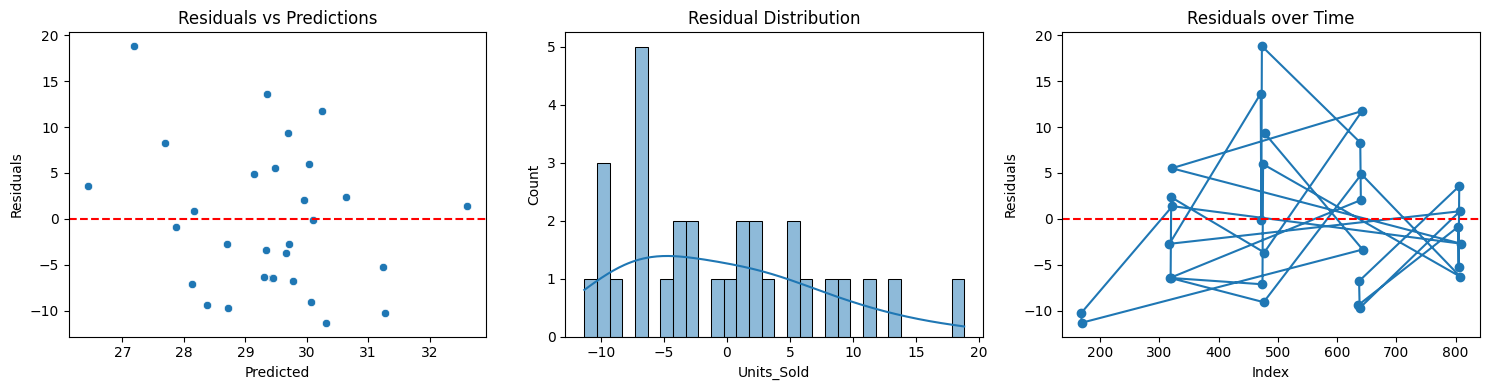

In [28]:
residuals = y_test - y_pred

plt.figure(figsize=(15,4))

# Residuals vs Predictions
plt.subplot(1,3,1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predictions")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

# Histogram of Residuals
plt.subplot(1,3,2)
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual Distribution")

# Time Series Residual Plot
plt.subplot(1,3,3)
plt.plot(y_test.index, residuals, marker='o', linestyle='-')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals over Time")
plt.xlabel("Index")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()

***Observations:***

The residuals vs predictions plot shows points scattered above and below zero, which is good since there’s no strong bias. However, the spread is wide, meaning the model often makes large over- or under-estimations.

The residual distribution is slightly right-skewed, indicating the model tends to underestimate sales more often than overestimate. The errors are not perfectly normally distributed, suggesting they are not fully random.

The residuals over time fluctuate sharply, with large spikes both positive and negative. This shows the model struggles at specific periods, though there is no clear seasonal pattern.

Overall, the RandomForest model captures general trends but leaves high variance in errors. 

#### Limitations

Data Scope: The dataset covers only 1,000 records, which may not fully represent long-term sales patterns or seasonality effects.

Feature Coverage: Important external drivers such as holidays, competitor activity, or economic conditions are missing, limiting the model’s ability to capture real-world demand influences.

Model Performance: The Random Forest model showed weak predictive power (negative R²), indicating it struggles to explain sales variation.

Residual Patterns: Residuals are not randomly distributed, suggesting the model has bias and may underperform on unseen data.

Data Granularity: Data is aggregated at daily product-category level but does not account for store-level or regional variations, which could impact accuracy.

#### Recommendations

Expand Dataset: Collect more historical data to capture seasonality, promotions, and long-term sales cycles.

Add External Factors: Incorporate holiday calendars, competitor pricing, customer demographics, and macroeconomic indicators to improve predictions.

Model Improvement: Explore advanced models (e.g., Gradient Boosting, XGBoost, or Neural Networks) and compare performance.

Segmentation Analysis: Build separate models for different customer segments or product categories to capture unique demand drivers.

Regular Monitoring: Continuously track prediction errors and retrain models as new sales data becomes available.

Use Forecasts with Caution: Treat current forecasts as directional rather than exact values, given the high error margins.

In [29]:
import joblib
joblib.dump(best_rf_pipe, "best_model.pkl")

['best_model.pkl']